# Пример прогнозирования на основе детальных транзакционных данных

In [1]:
import pandas as pd # Работа с табличными данными и рядами
import numpy as np # Работа с массивами
import statsmodels.api as sm # Анализ и моделирование временных рядов
import seaborn as sns # Визуализация
import matplotlib.pyplot as plt # Визуализация

# Графики встраиваются в блокнот:
%matplotlib inline
sns.set() # Стиль графиков

## Загрузка данных 

Исходные данные - строки заказов в файле `orders.txt`. Загрузим часть столбцов из файла:

In [2]:
orders = pd.read_csv('orders.txt', # файл с данными
                     sep='\t', # разделитель столбцов - табуляция
                     encoding='windows-1251', # Кодировка - Windows
                     usecols=['КодЗаказа', 'ДатаРазмещения', 'Марка', 'Категория', 'Количество'], # какие нужны столбцы
                     parse_dates=['ДатаРазмещения'],  # столбец с датами
                     date_format='%d.%m.%Y'  # формат даты
                    ) # файл с данными заказов
orders.head()

,КодЗаказа,ДатаРазмещения,Марка,Категория,Количество
0,10248,1996-07-04,Chartreuse verte,Напитки,1
1,10248,1996-07-04,NuNuCa Nuss-Nougat-Creme,Кондитерские изделия,23
2,10248,1996-07-04,Camembert Pierrot,Молочные продукты,4
3,10248,1996-07-04,Mishi Kobe Niku,Мясо/птица,5
4,10248,1996-07-04,Jack's New England Clam Chowder,Рыбопродукты,10


## Получение временного ряда

Для применения моделей прогнозирования необходимо привести данные к временному ряду (суммарное количество за каждый месяц).

Округляем даты заказов до месяца:

In [3]:
orders['Месяц'] = orders['ДатаРазмещения']  + pd.offsets.MonthBegin(-1)
orders.head()

,КодЗаказа,ДатаРазмещения,Марка,Категория,Количество,Месяц
0,10248,1996-07-04,Chartreuse verte,Напитки,1,1996-07-01
1,10248,1996-07-04,NuNuCa Nuss-Nougat-Creme,Кондитерские изделия,23,1996-07-01
2,10248,1996-07-04,Camembert Pierrot,Молочные продукты,4,1996-07-01
3,10248,1996-07-04,Mishi Kobe Niku,Мясо/птица,5,1996-07-01
4,10248,1996-07-04,Jack's New England Clam Chowder,Рыбопродукты,10,1996-07-01


In [4]:
monthly_quantity = orders.groupby(['Месяц', 'Марка'], as_index=False)['Количество'].sum()
monthly_quantity.head(14)

,Месяц,Марка,Количество
0,1996-07-01,Boston Crab Meat,51
1,1996-07-01,Camembert Pierrot,4
2,1996-07-01,Chang,35
3,1996-07-01,Chartreuse verte,51
4,1996-07-01,Chocolade,40
5,1996-07-01,Cote de Blaye,48
6,1996-07-01,Escargots de Bourgogne,100
7,1996-07-01,Filo Mix,15
8,1996-07-01,Gnocchi di nonna Alice,65
9,1996-07-01,Gorgonzola Telino,6


## Проблема пропущенных значений

Отберем данные по 3 наиболее продаваемым товарам

In [5]:
best_items_qty = orders.groupby(['Марка'], as_index=False)['Количество'].sum()\
                        .sort_values(by='Количество', ascending=False, ignore_index=True)
best_items_qty.head(3)

,Марка,Количество
0,Raclette Courdavault,1577
1,Escargots de Bourgogne,1496
2,Original Frankfurter grune Sosse,1397


Список наиболее продаваемых товаров

In [6]:
best_items = best_items_qty[:3]['Марка'].unique()
best_items

array(['Raclette Courdavault', 'Escargots de Bourgogne',
       'Original Frankfurter grune Sosse'], dtype=object)

Продажи по месяцам для наиболее продаваемых товаров

In [7]:
best_monthly_quantity = monthly_quantity[monthly_quantity['Марка'].isin(best_items)]
best_monthly_quantity.head(9)

,Месяц,Марка,Количество
6,1996-07-01,Escargots de Bourgogne,100
20,1996-07-01,Original Frankfurter grune Sosse,20
25,1996-07-01,Raclette Courdavault,40
50,1996-08-01,Escargots de Bourgogne,21
67,1996-08-01,Original Frankfurter grune Sosse,55
71,1996-08-01,Raclette Courdavault,76
96,1996-09-01,Escargots de Bourgogne,40
130,1996-10-01,Escargots de Bourgogne,58
151,1996-10-01,Original Frankfurter grune Sosse,85


Для некоторых товаров пропущены периоды, в которые не было продаж.
Более очевидно это в сводной таблице:

In [8]:
monthly_pivot = best_monthly_quantity.pivot_table(index='Месяц', columns='Марка', values='Количество', aggfunc='sum')
monthly_pivot.head(4)

Марка,Escargots de Bourgogne,Original Frankfurter grune Sosse,Raclette Courdavault
Месяц,,,
1996-07-01,100.0,20.0,40.0
1996-08-01,21.0,55.0,76.0
1996-09-01,40.0,NaN,NaN
1996-10-01,58.0,85.0,NaN


В таблице видно, что отсутствуют продажи в сентябре для двух товаров.
В "длинной" таблице выше эти периоды просто отсутствовали. Поэтому при использовании моделей временных рядов будет получаться некорректный результат, т.к. данные не являются временным рядом с регулярными наблюдениями.

На графике ниже видно, что в данных много пропусков.

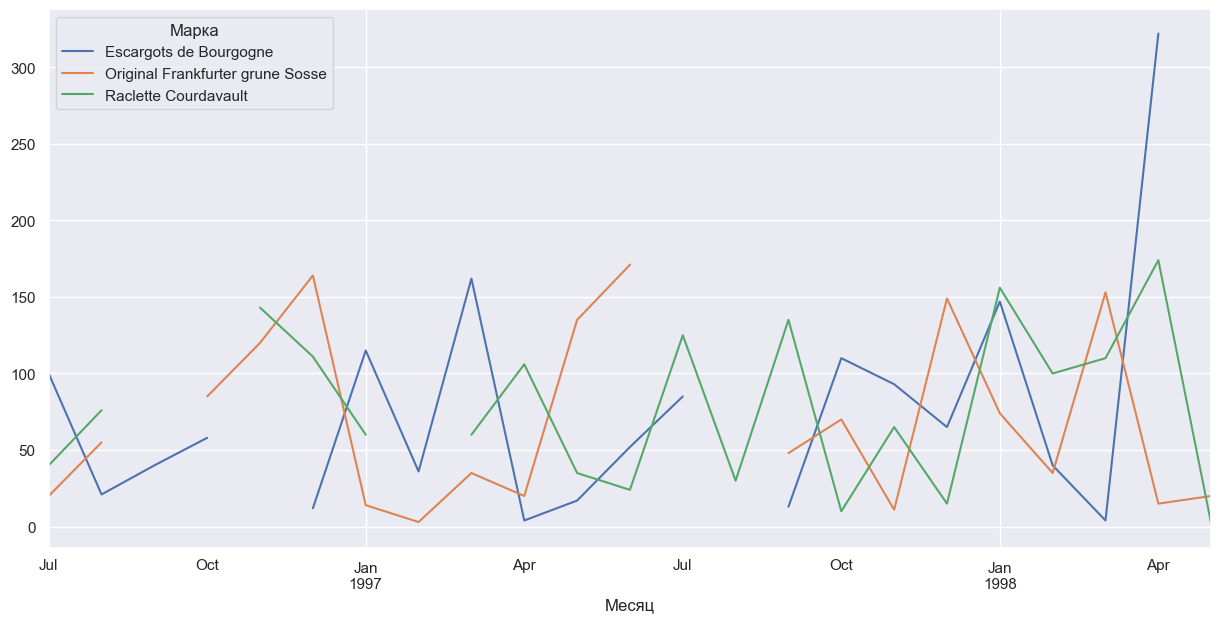

In [9]:
monthly_pivot.plot(figsize=(15, 7))
plt.show()

Чтобы устранить проблему, необходимо восстановить пропущенные периоды.

Один из вариантов - получить все возможные сочетания периодов и товаров, т.е. декартово произведение множеств периодов и товаров. Чтобы получить множество периодов, лучше всего использовать все данные по продажам. Маловероятно, чтобы в течение целого периода компания вообще ничего не смогла продать.

In [10]:
all_periods = orders[['Месяц']].drop_duplicates()
all_periods


,Месяц
0,1996-07-01
64,1996-08-01
133,1996-09-01
195,1996-10-01
268,1996-11-01
332,1996-12-01
420,1997-01-01
498,1997-02-01
577,1997-03-01
656,1997-04-01


По товарам используем только три наиболее продаваемых товара:

In [11]:
all_items = best_monthly_quantity[['Марка']].drop_duplicates()
all_items

,Марка
6,Escargots de Bourgogne
20,Original Frankfurter grune Sosse
25,Raclette Courdavault


Все сочетания периодов и товаров:


In [12]:
all_combinations = all_periods.merge(all_items, how='cross')
all_combinations.head(9)


,Месяц,Марка
0,1996-07-01,Escargots de Bourgogne
1,1996-07-01,Original Frankfurter grune Sosse
2,1996-07-01,Raclette Courdavault
3,1996-08-01,Escargots de Bourgogne
4,1996-08-01,Original Frankfurter grune Sosse
5,1996-08-01,Raclette Courdavault
6,1996-09-01,Escargots de Bourgogne
7,1996-09-01,Original Frankfurter grune Sosse
8,1996-09-01,Raclette Courdavault


Теперь в данных есть все сочетания периодов и товаров. Добавим к этой таблице известные данные о продажах с помощью левого соединения.


In [13]:
best_monthly_quantity_restored = all_combinations.merge(best_monthly_quantity, 
                                                        how = 'left',
                                                        left_on=['Месяц', 'Марка'],
                                                        right_on=['Месяц', 'Марка'])
best_monthly_quantity_restored.head(9)

,Месяц,Марка,Количество
0,1996-07-01,Escargots de Bourgogne,100.0
1,1996-07-01,Original Frankfurter grune Sosse,20.0
2,1996-07-01,Raclette Courdavault,40.0
3,1996-08-01,Escargots de Bourgogne,21.0
4,1996-08-01,Original Frankfurter grune Sosse,55.0
5,1996-08-01,Raclette Courdavault,76.0
6,1996-09-01,Escargots de Bourgogne,40.0
7,1996-09-01,Original Frankfurter grune Sosse,NaN
8,1996-09-01,Raclette Courdavault,NaN


Теперь видно, что в данных появились пропущенные периоды, однако значения временного ряда для этих периодов отсутствуют.

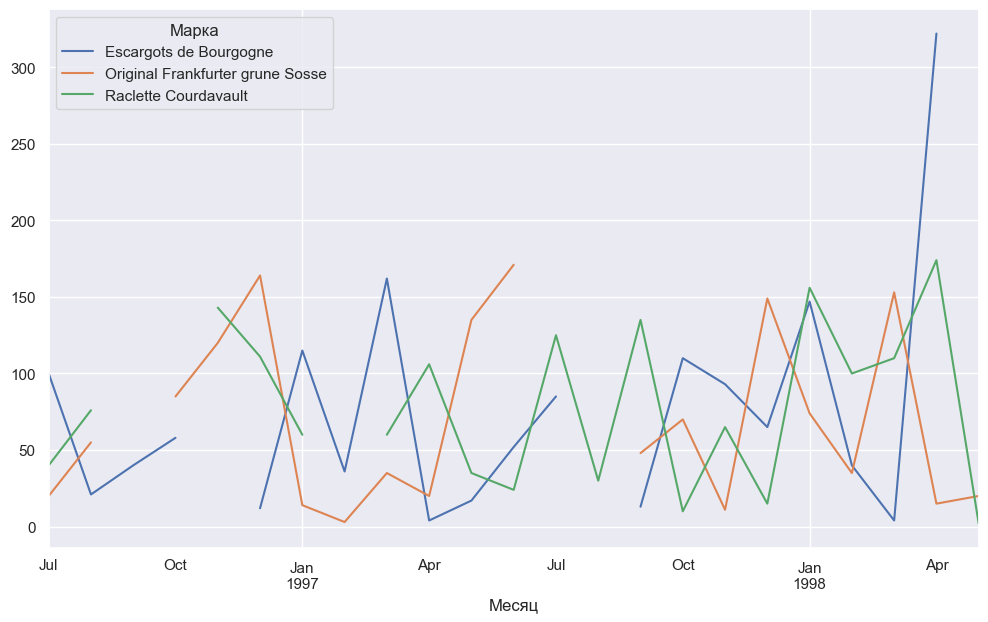

In [14]:
best_monthly_quantity_restored.pivot(index='Месяц', columns='Марка', values='Количество').plot(figsize=(12, 7))
plt.show()

## Заполнение пропусков

Рассмотрим, как можно восстановить пропущенные значения. Это необходимо делать для ряда продаж каждого товара в отдельности.
В этом примере рассмотрим товар `Escargots de Bourgogne`

In [15]:
sales_escargots = best_monthly_quantity_restored.query('Марка=="Escargots de Bourgogne"').set_index('Месяц')['Количество']
sales_escargots

Месяц
1996-07-01    100.0
1996-08-01     21.0
1996-09-01     40.0
1996-10-01     58.0
1996-11-01      NaN
1996-12-01     12.0
1997-01-01    115.0
1997-02-01     36.0
1997-03-01    162.0
1997-04-01      4.0
1997-05-01     17.0
1997-06-01     52.0
1997-07-01     85.0
1997-08-01      NaN
1997-09-01     13.0
1997-10-01    110.0
1997-11-01     93.0
1997-12-01     65.0
1998-01-01    147.0
1998-02-01     40.0
1998-03-01      4.0
1998-04-01    322.0
1998-05-01      NaN
Name: Количество, dtype: float64

Получили временной ряд. Для заполнения пропусков можно воспользоваться встроенными методами Pandas:

 - заполнение константой или последним известным значением - [.fillna](https://pandas.pydata.org/docs/reference/api/pandas.Series.fillna.html)
 - интерполяция пропущенных значений - [.interpolate](https://pandas.pydata.org/docs/reference/api/pandas.Series.interpolate.html)
 - заполнение последним известным значением - [.ffill](https://pandas.pydata.org/docs/reference/api/pandas.Series.ffill.html)

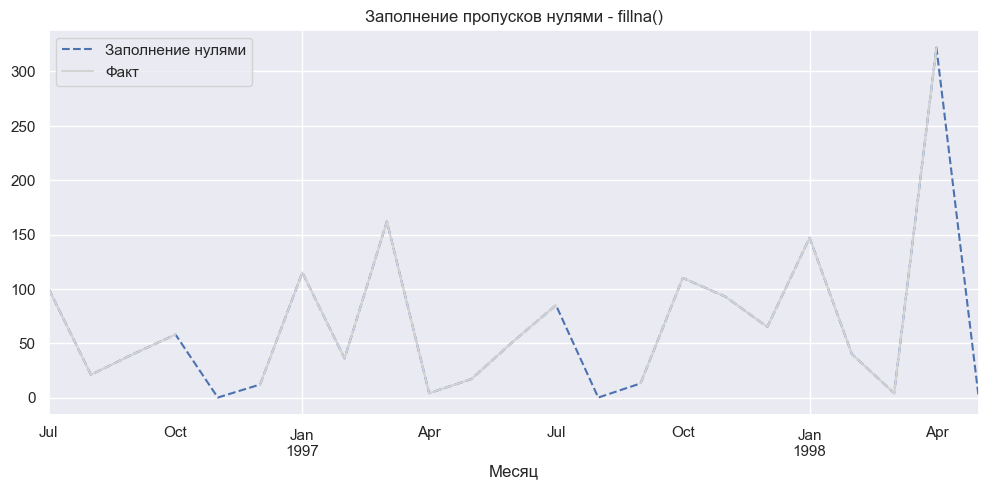

In [16]:
sales_escargots.fillna(value=0).plot(label = 'Заполнение нулями', linestyle='dashed', figsize=(12,5))
sales_escargots.plot(color='lightgray', label='Факт')
plt.title('Заполнение пропусков нулями - fillna()')
plt.legend()
plt.show()

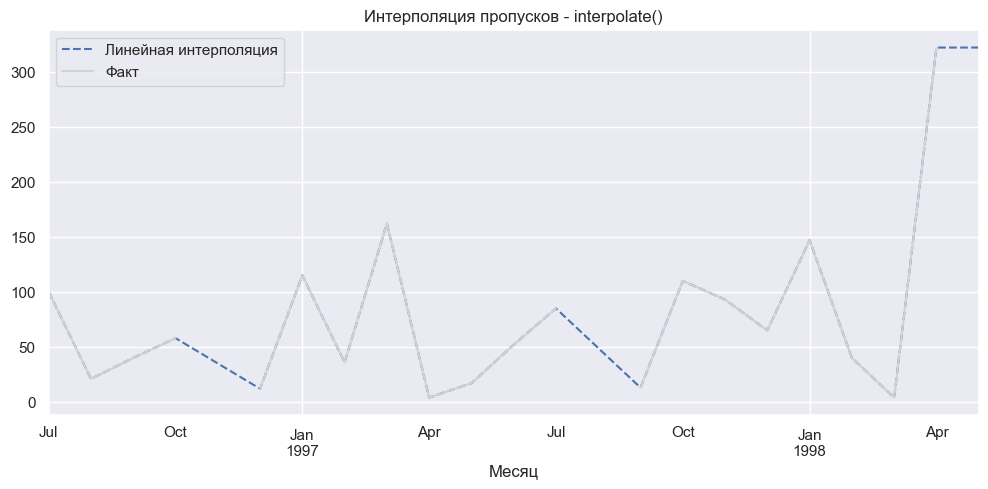

In [17]:
sales_escargots.interpolate(method='linear').plot(label = 'Линейная интерполяция', linestyle='dashed', figsize=(12,5))
sales_escargots.plot(color='lightgray', label='Факт')
plt.title('Интерполяция пропусков - interpolate()')
plt.legend()
plt.show()

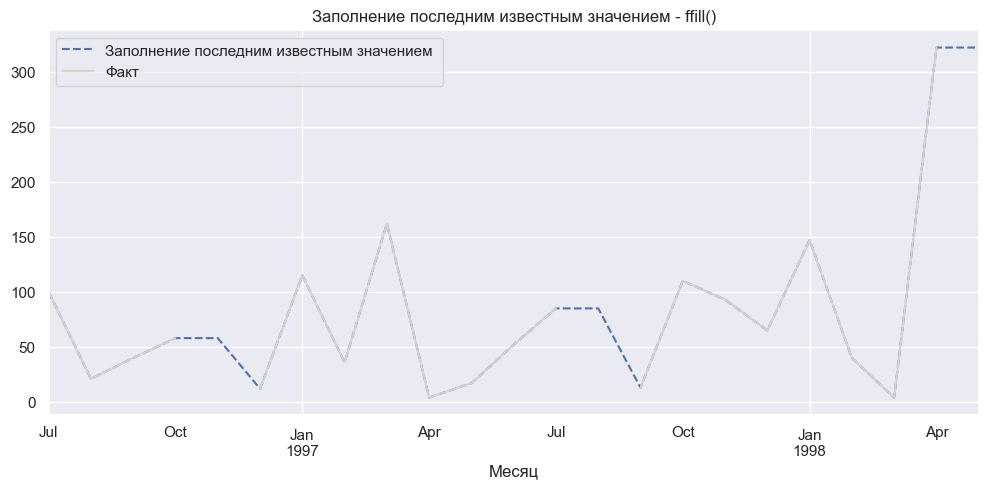

In [18]:
sales_escargots.ffill().plot(label = 'Заполнение последним известным значением ', linestyle='dashed', figsize=(12,5))
sales_escargots.plot(color='lightgray', label='Факт')
plt.title('Заполнение последним известным значением - ffill()')
plt.legend()
plt.show()

Рассмотренные выше методы плохо подходят для сезонных временных рядов. Для таких данных лучший результат может дать моделирование данных, например, при помощи сезонной декомпозиции.

Воспользуемся методом [STL-декомпозиции](https://www.statsmodels.org/dev/examples/notebooks/generated/stl_decomposition.html). Здесь при выделении тренда не теряются данные в начале и в конце ряда, в отличие от метода классической сезонной декомпозиции.

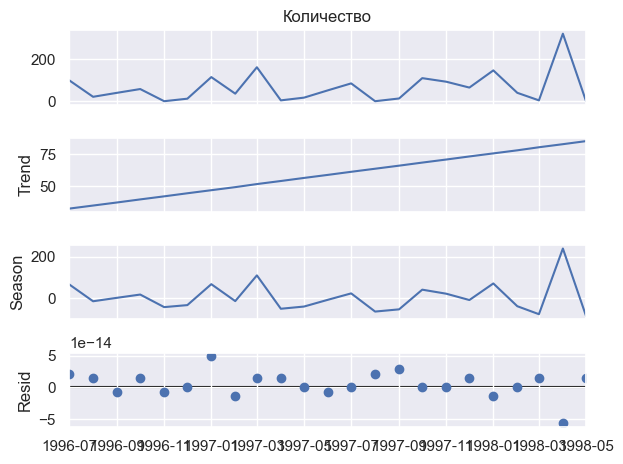

In [19]:
from statsmodels.tsa.seasonal import STL

sales_escargots_stl = STL(sales_escargots.fillna(0),  # Декомпозиция не работает с пропусками, поэтому заполним их нулями
                          seasonal=13, # Окно сглаживания для сезонности
                         ).fit()
sales_escargots_stl.plot()
plt.show()

Сравним модель декомозиции с фактом:

In [20]:
sales_escargots_model = sales_escargots_stl.trend +  sales_escargots_stl.seasonal # Расчет значений по модели декомпозиции

sales_escargots_restored = sales_escargots.combine_first(sales_escargots_model) # Используем первое непустое значение из факта и модели



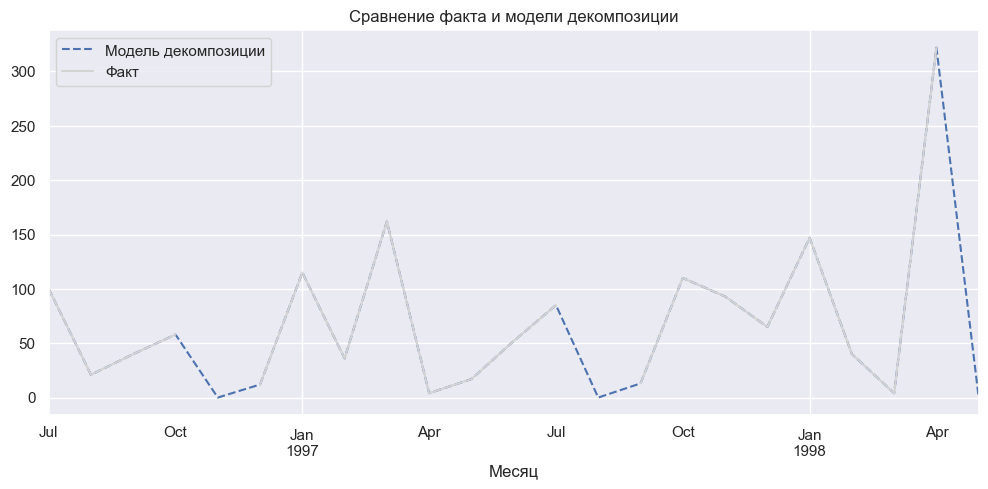

In [21]:
sales_escargots_model.plot(label = 'Модель декомпозиции', linestyle='dashed', figsize=(12,5))
sales_escargots.plot(color='lightgray', label='Факт')
plt.title('Сравнение факта и модели декомпозиции')
plt.legend()
plt.show()

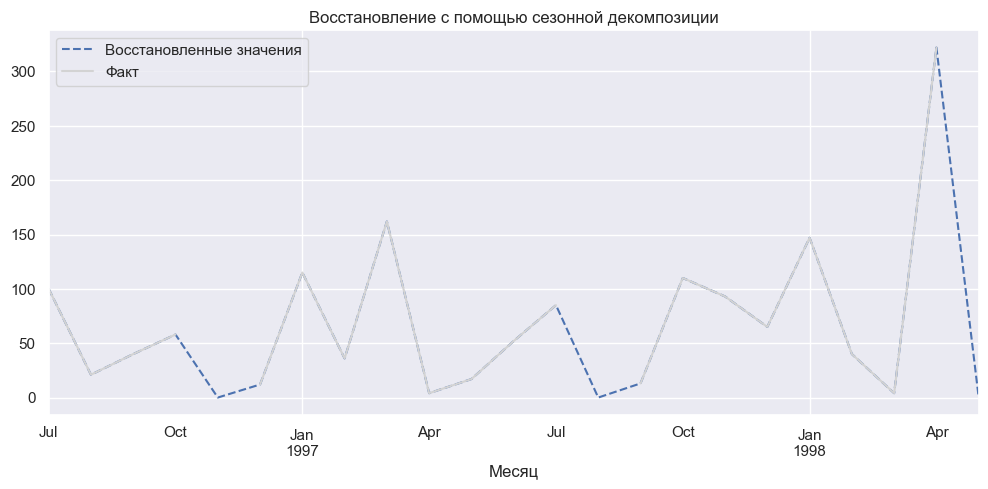

In [22]:
sales_escargots_restored.plot(label = 'Восстановленные значения', linestyle='dashed', figsize=(12,5))
sales_escargots.plot(color='lightgray', label='Факт')
plt.title('Восстановление с помощью сезонной декомпозиции')
plt.legend()
plt.show()

## Прогнозирование

Используя данные с заполненными пропусками, можно строить прогнозы.

In [23]:
from statsmodels.tsa.api import ExponentialSmoothing

sales_escargots_m_winters = ExponentialSmoothing(sales_escargots.interpolate(), # Метод не работает при нулевых значениях факта
                                                 freq='MS',
                                                 trend='Additive',
                                                 seasonal='Multiplicative',
                                                 initialization_method='known', #Автоопределение не работает при <2 сезонных циклах
                                                 initial_level=sales_escargots.mean(), #Среднее ряда
                                                 initial_trend=sales_escargots.diff(1).mean(), #Среднее приращение ряда
                                                 initial_seasonal=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1 ] # начальные сезонные индексы
                                                )\
                            .fit(optimized=False,
                                smoothing_level=0.2,
                                smoothing_trend=0.2,
                                smoothing_seasonal=0.2)

sales_escargots_m_winters.summary()

Dep. Variable:,Количество,No. Observations:,23
Model:,ExponentialSmoothing,SSE,195011.275
Optimized:,False,AIC,240.042
Trend:,Additive,BIC,258.210
Seasonal:,Multiplicative,AICC,411.042
Seasonal Periods:,12,Date:,"Thu, 05 Dec 2024"
Box-Cox:,False,Time:,10:09:02
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.2000000,alpha,False
smoothing_trend,0.2000000,beta,False


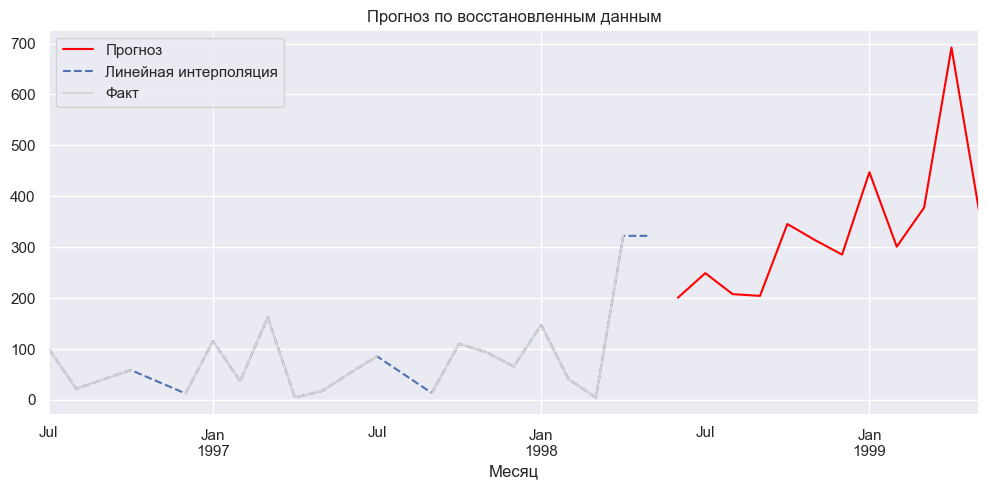

In [24]:
sales_escargots_m_winters.forecast(12).plot(label = 'Прогноз', linestyle='solid', color='red', figsize=(12,5))
sales_escargots.interpolate(method='linear').plot(label = 'Линейная интерполяция', linestyle='dashed')
sales_escargots.plot(color='lightgray', label='Факт')
plt.title('Прогноз по восстановленным данным')
plt.legend()
plt.show()